In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats
from scipy import linalg

import sys
sys.path.insert(0,'..')
import specsens as ss

In [2]:
sample_freq = 1e6  # in Hz
length = 1.0  # in s
signal_strength = 0.0  # in dB
noise_strength = 0.0  # in dB

wm = ss.WirelessMicrophone(f_sample=sample_freq, t_sec=length)
sig = wm.get_soft(f_center=1.e5, dB=True, power=signal_strength)
sig += wm.get_soft(f_center=1.25e5, dB=True, power=signal_strength)
sig += wm.get_soft(f_center=1.5e5, dB=True, power=signal_strength)
sig += wm.get_soft(f_center=1.75e5, dB=True, power=signal_strength)
sig += wm.get_soft(f_center=2.e5, dB=True, power=signal_strength)
sig += wm.get_soft(f_center=-1.e5, dB=True, power=signal_strength)
sig += wm.get_soft(f_center=-2.e5, dB=True, power=signal_strength)

wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length)
noise = wgn.get_signal(power=noise_strength, dB=True)

assert wm.num_samples == wgn.num_samples  # ensure noise and signal have same length
num_samples = wm.num_samples

both = sig + noise  # create actual signal ('both') comprising of signal and additive white gaussian noise (AWGN)

print('Signal power: %.2f dB' % (ss.util.signal_power(sig, dB=True)))
print('Noise power:  %.2f dB' % (ss.util.signal_power(noise, dB=True)))
print('SNR:          %.2f dB' % (ss.util.snr(sig, noise, dB=True)))
print('Num Samples:  %d ' % (num_samples))

# Note, that Parseval's theorem holds
from scipy import fft
print("Freq Energy:  %.2f" % (np.sum(np.abs(fft.fft(both))**2)/sample_freq))
print("Time Energy:  %.2f" % (np.sum(np.abs(both)**2)))

Signal power: 8.45 dB
Noise power:  0.01 dB
SNR:          8.44 dB
Num Samples:  1000000 
Freq Energy:  8003568.68
Time Energy:  8003568.68


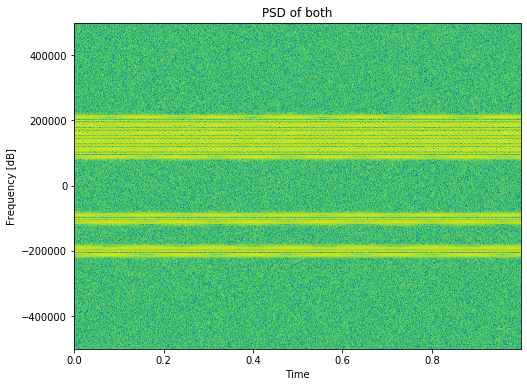

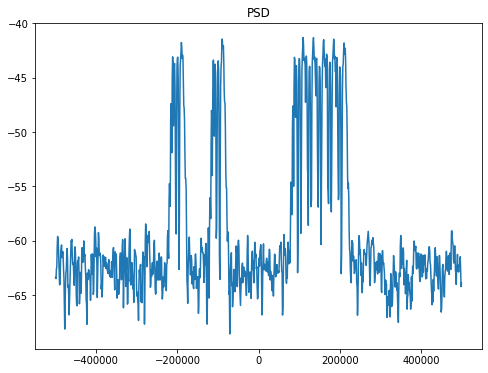

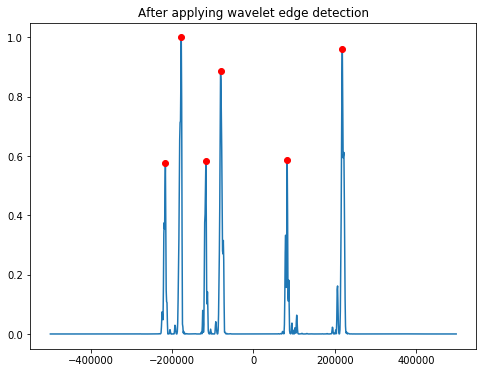

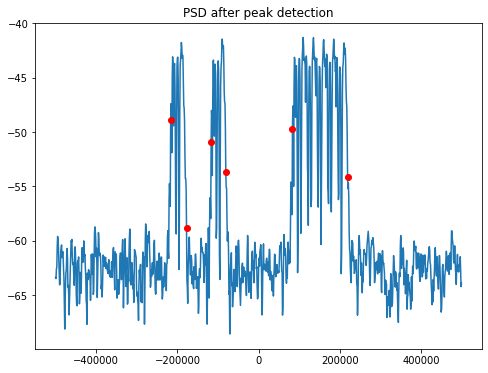

In [3]:
sft = ss.Stft(n=1024, window='flattop')
f, t, x = sft.spectogram(both, sample_freq, normalized=True, dB=True)

psd = ss.util_wide.psd_average(spectogram=x, start=10, stop=20)

prod, peak, peakf = ss.band_detect(psd,
                                   f,
                                   scale=5,
                                   min_height=0.2,
                                   min_freq=3e4)

# Plot the wideband signal in 2d
ss.plot2d(both,
          sample_freq,
          window='flattop',
          nfft=1024,
          dB=True,
          type='our',
          title='both')

plt.figure(figsize=(8, 6))
plt.title('PSD')
plt.plot(f, psd)
plt.show()

plt.figure(figsize=(8, 6))
plt.title('After applying wavelet edge detection')
plt.plot(f, prod)
plt.plot(peakf, prod[peak], 'ro')
plt.show()

plt.figure(figsize=(8, 6))
plt.title('PSD after peak detection')
plt.plot(f, psd)
plt.plot(peakf, psd[peak], 'ro')
plt.show()